# Session 2: Machine Learning Fundamentals 

### Learning outcomes

From this lecture, you will be able to 

- explain how decision boundaries change with the `max_depth` hyperparameter;
- explain the concept of generalization;
- appropriately split a dataset into train and test sets using `train_test_split` function;
- explain the difference between train, validation, test, and "deployment" data;
- identify the difference between training error, validation error, and test error;
- explain cross-validation and use `cross_val_score` and `cross_validate` to calculate cross-validation error;
- recognize overfitting and/or underfitting by looking at train and test scores;
- explain why it is generally not possible to get a perfect test score (zero test error) on a supervised learning problem;
- describe the fundamental tradeoff between training score and the train-test gap;
- state the golden rule;
- start to build a standard recipe for supervised learning: train/test split, hyperparameter tuning with cross-validation, test on test set.

<br><br><br><br>

## Generalization [[video](https://youtu.be/iS2hsRRlc2M)]

### Big picture and motivation 

In machine learning we want to learn a mapping function from labeled data so that we can predict labels of **unlabeled** data. For example, suppose we want to build a spam filtering system.  We will take a large number of spam/non-spam messages from the past, learn patterns associated with spam/non-spam from them, and predict whether **a new incoming message** in someone's inbox is spam or non-spam based on these patterns. 

So we want to learn from the past but ultimately we want to apply it on the future email messages. 

### Model complexity and training accuracy

To learn about generalization, we will start by understanding more about how our models make decisions and look at their decision boundaries, a way to visualize what sort of examples will be classified as positive and negative. 

Let's examine how does the decision boundary change for varying model complexities (different tree depths). 

#### Example: Predicting country of a city using its longitude and latitude 

Imagine that you are given longitude and latitude of some border cities of USA and Canada along with which country they belong to. Using this training data, you are supposed to come up with a classification model to predict whether a given longitude and latitude combination is in the USA or Canada. 

In [1]:
### US Canada cities data
import pandas as pd
df = pd.read_csv("data/canada_usa_cities.csv")
df

,longitude,latitude,country
0,-130.0437,55.9773,USA
1,-134.4197,58.3019,USA
2,-123.0780,48.9854,USA
3,-122.7436,48.9881,USA
4,-122.2691,48.9951,USA
...,...,...,...
204,-72.7218,45.3990,Canada
205,-66.6458,45.9664,Canada
206,-79.2506,42.9931,Canada
207,-72.9406,45.6275,Canada


In [2]:
# Features
X = df[["longitude", "latitude"]]

In [3]:
# Target
y = df["country"]

We will use seaborn for visualization but many other libraries work too.

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

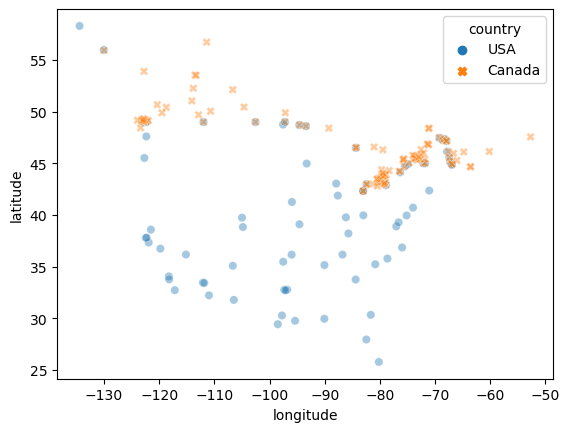

In [4]:
import seaborn as sns


sns.scatterplot(x=X['longitude'], y=X['latitude'], hue=y, style=y, alpha=0.4)

In real life we know what's the boundary between USA and Canada. Can our model learn it?

<!-- ![](img/canada-us-border.jpg) -->

<img src="img/canada-us-border.jpg" height="500" width="500"> 

[Source](https://sovereignlimits.com/blog/u-s-canada-border-history-disputes)

Here we want to pretend that we do not know this boundary and we want to infer this boundary based on the limited training examples given to us.
scikit-learn contains functionality to plot this boundary

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

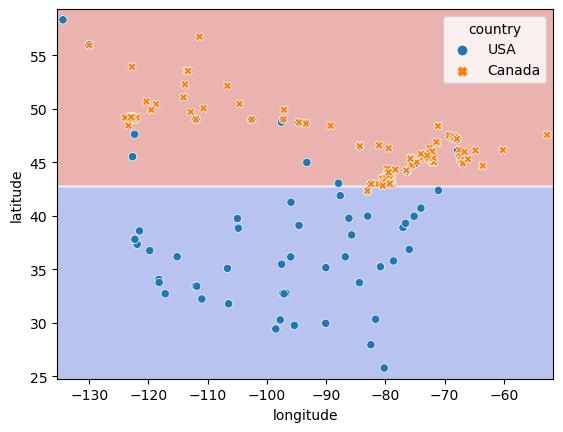

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import DecisionBoundaryDisplay

model = DecisionTreeClassifier(max_depth=1)
model.fit(X, y)

DecisionBoundaryDisplay.from_estimator(model, X, response_method='predict', alpha=0.4, cmap='coolwarm_r')
sns.scatterplot(x=X['longitude'], y=X['latitude'], hue=y, style=y)

Above we plotted a single max_depth, let's explore how the boundary changes for multiple values of this hyperparameter. We will use the interactive widget library `panel` to help us with this. This library can be used both inside the notebook and to build dashboard online, so it is quite handy. This is how panel works in a nutshell:

In [6]:
import panel as pn

def f(x):
    return x**2

pn.interact(f, x=1)

Column
    [0] Column
        [0] IntSlider(end=3, name='x', start=-1, value=1)
    [1] Row
        [0] Str(int, name='interactive00108')

Let's wrap the function we created before in a panel widget to explore how the tree depth impacts the decision boundary.

Column
    [0] Column
        [0] IntSlider(end=13, start=1, value=1)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00138')
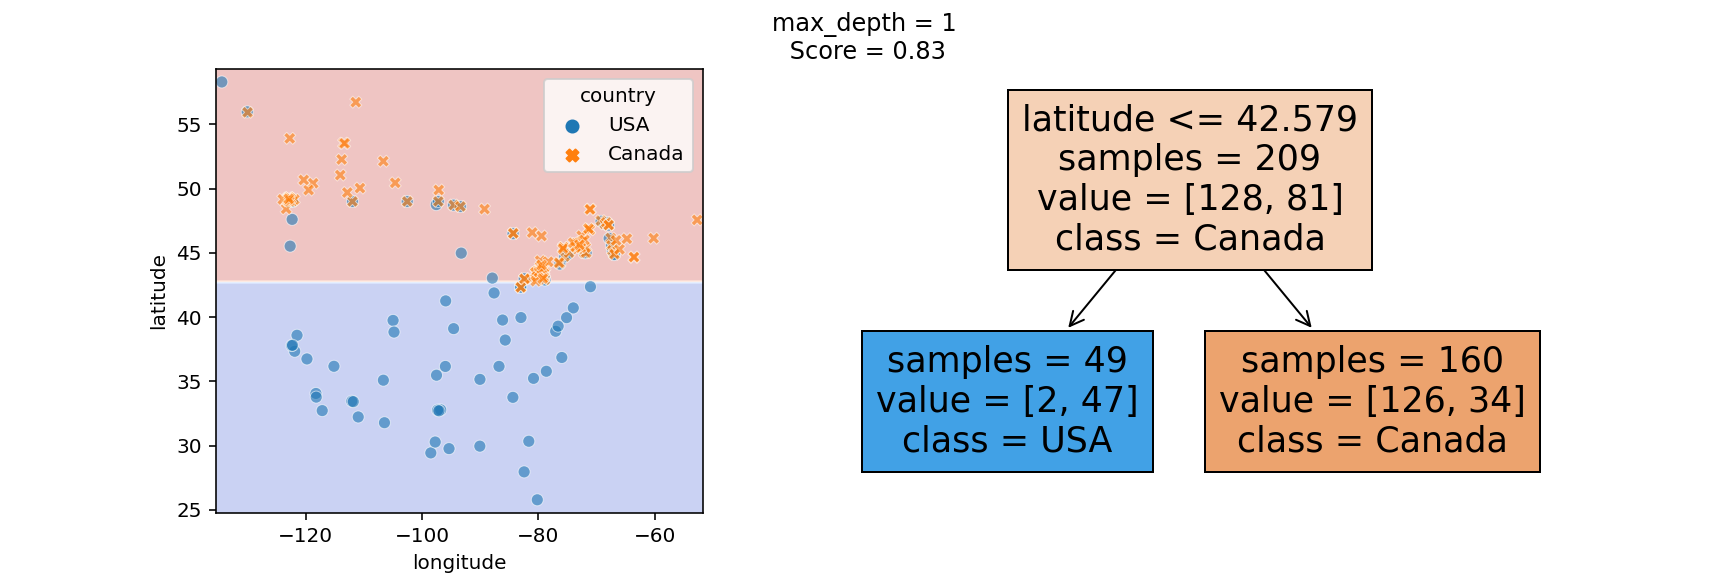

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


pn.extension()

def decision_boundary(depth):
    model = DecisionTreeClassifier(max_depth=depth, random_state=109)
    model.fit(X, y)

    # Set up figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), width_ratios=[2, 3])
    fig.suptitle(f'max_depth = {depth}\n Score = {round(model.score(X, y), 2)}')

    # Plot decision boundary
    DecisionBoundaryDisplay.from_estimator(model, X, response_method='predict', alpha=0.3, cmap='coolwarm_r', ax=ax[0])
    plt.close()  # prevent two figures from showing up
    sns.scatterplot(x=X['longitude'], y=X['latitude'], hue=y, style=y, ax=ax[0], alpha=0.6)

    # Plot decision tree
    plot_tree(
        model,
        feature_names=model.feature_names_in_,
        class_names=model.classes_,
        filled=True,
        impurity=False,
        ax=ax[1]
    )
    plt.close()  # prevent two figures from showing up

    return fig

pn.interact(decision_boundary, depth=pn.widgets.IntSlider(start=1, end=13))

We can see that as the model becomes more specific to the training data, it's complexity increases (it creates more rules about how to split the data in the tree). As the complexity increases, the score on the training data gets better and the model is eventually able to describe the training data perfectly. We can take a systematic view of this by plotting the accuracy versus the max depth.

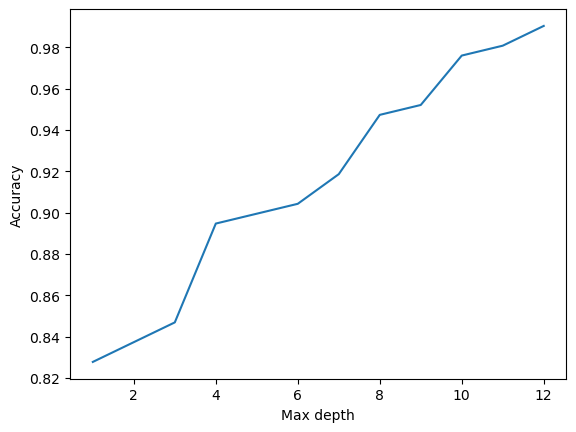

In [8]:
import matplotlib.pyplot as plt

max_depths = range(1, 13)
accuracies = []
for max_depth in max_depths:
    accuracy = DecisionTreeClassifier(max_depth=max_depth, random_state=109).fit(X, y).score(
        X, y
    )
    accuracies.append(accuracy)
plt.plot(max_depths, accuracies)
plt.xlabel("Max depth")
plt.ylabel("Accuracy");

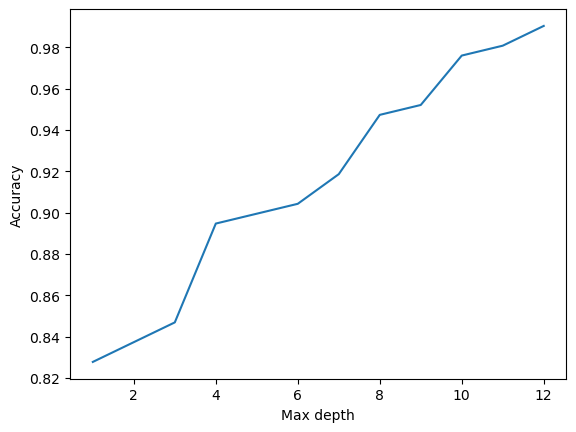

In [9]:
import matplotlib.pyplot as plt

max_depths = range(1, 13)
accuracies = []
for max_depth in max_depths:
    accuracy = DecisionTreeClassifier(max_depth=max_depth, random_state=109).fit(X, y).score(
        X, y
    )
    accuracies.append(accuracy)
plt.plot(max_depths, accuracies)
plt.xlabel("Max depth")
plt.ylabel("Accuracy");

- Our model has 99% accuracy for depth = 13!! 
- But it's also becoming more and more complex and specific to the training data.  
- Does this mean that higher depth is better?

**How can we generalize from what we've seen to what we haven't seen?** 

- We want the model to pickup on the true signal in the data, but not random fluctutaions.
- In other words, how can we make sure that the model we have built would do reasonably well on new data in the wild when it's deployed? 

![](img/eva-think.png)

<br><br><br><br>

### Generalization: Fundamental goal of ML

> **To generalize beyond what we see in the training examples**

We only have access to limited amount of training data and we want to learn a mapping function which would predict targets reasonably well for examples beyond this training data. 

### Training error vs. Generalization error 

- Given a model $M$, in ML, people usually talk about two kinds of errors:
    1. Error on the training data
    2. Error on the entire distribution of data
- Since we want to be able to predict the value of new points, we are interested in the error on the entire distribution     
    - ... **But we do not have access to the entire distribution** 😞
    - But we can pretend that 

<br><br><br><br>

## Data Splitting [[video](https://youtu.be/h2AEobwcUQw)]

### How to approximate generalization error? 

A common way is **data splitting**. 
- Randomly split the data into a training set and a test set.
- `fit` (train) a model on the training portion only. 
- `score` (assess) the trained model on the set aside test data to get a sense of how well the model would be able to generalize to data it hasn't seen during training.
- The kept aside data is our best guess of what a sample from the real distribution of data looks like, so it is probably similar to what the model will see in production when deployed.

![](img/eva-good-idea.png)

### Simple train/test split 

- The picture shows an 80%-20% split of a toy dataset with 10 examples. 
- The data is shuffled before splitting, to account for that their might be a relationship between the order and the target or features.
- Usually when we do machine learning we split the data before doing anything and lock away the test data in an imaginary chest. 

![](img/train-test-split.png)

<!-- <img src='img/train-test-split.png' width="1500" height="1500" /> -->

### The golden rule <a name="4"></a>

- Even though we care the most about test error **THE TEST DATA CANNOT INFLUENCE THE TRAINING PHASE IN ANY WAY**. 
- We have to be very careful not to violate it while developing our ML pipeline. 
- Even experts end up breaking it sometimes which leads to misleading results and lack of generalization on the real data. 

Let's demostrate a train/test split using the USA/Canada data.

#### Creating `train_df` and `test_df`


In [10]:
from sklearn.model_selection import train_test_split


df = pd.read_csv("data/canada_usa_cities.csv")

train_df, test_df = train_test_split(
    #129, 132 136
    df, test_size=0.2, random_state=132
)

# We can train our model and do EDA on our train data
X_train = train_df.drop(columns=["country"])
y_train = train_df["country"]

# We don't look at our test data until we score the model
X_test = test_df.drop(columns=["country"])
y_test = test_df["country"]

train_df.head()

,longitude,latitude,country
62,-106.6510,35.0841,USA
200,-72.0885,46.0004,Canada
161,-60.1941,46.1380,Canada
32,-118.2428,34.0537,USA
180,-73.4528,45.7326,Canada


- Useful arguments of `train_test_split`: 
    - `test_size`
    - `train_size` 
    - `random_state`

#### `test_size`, `train_size` arguments

- Let's us specify how we want to split the data. 
- We can specify either of the two. See the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
- There is no hard and fast rule on what split sizes should we use. 
    - It depends upon how much data is available to you. 
- Some common splits are 90/10, 80/20, 70/30 (training/test).
- In the above example, we used 80/20 split. 

#### `random_state` argument

- The data is shuffled before splitting which is crucial step.
- The `random_state` argument controls this shuffling. 
- Useful when you want reproducible results. 

Let's examine the train and test accuracies after fitting the model on the train data only.

In [11]:
model = DecisionTreeClassifier(random_state=109)
model.fit(X_train, y_train)

# Train accuracy
model.score(X_train, y_train)

1.0

In [12]:
# Test accuracy
model.score(X_test, y_test)

0.7380952380952381

It is much worse on the test data, why?
Because the decision boundaries are very specific to the training data and don't generalize well to the full distribution!

In [13]:
X_train

,longitude,latitude
62,-106.6510,35.0841
200,-72.0885,46.0004
161,-60.1941,46.1380
32,-118.2428,34.0537
180,-73.4528,45.7326
...,...,...
170,-79.0906,43.8358
178,-73.6875,45.5089
81,-129.9912,55.9383
58,-90.0516,35.1490


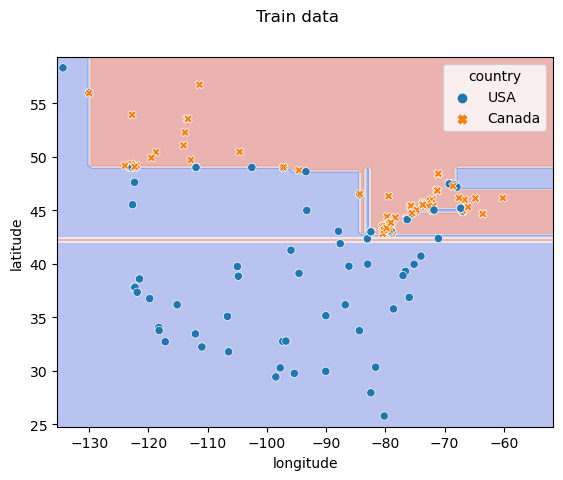

In [14]:
disp = DecisionBoundaryDisplay.from_estimator(model, X, response_method='predict', alpha=0.4, cmap='coolwarm_r')
sns.scatterplot(x=X_train['longitude'], y=X_train['latitude'], hue=y_train, style=y_train)
# sns.scatterplot(x=X['longitude'], y=X['latitude'], hue=y, style=y)
disp.figure_.suptitle('Train data');

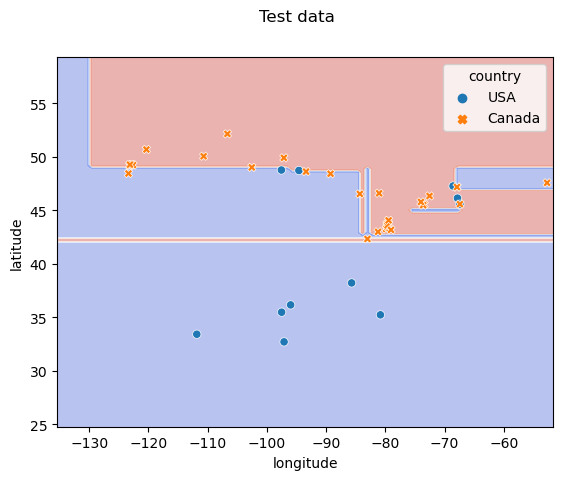

In [15]:
disp = DecisionBoundaryDisplay.from_estimator(model, X, response_method='predict', alpha=0.4, cmap='coolwarm_r')
sns.scatterplot(x=X_test['longitude'], y=X_test['latitude'], hue=y_test, style=y_test)
disp.figure_.suptitle('Test data');

We can see that a less specific to the training data, we would have captured the general trend in the data better and scored higher on the test data.

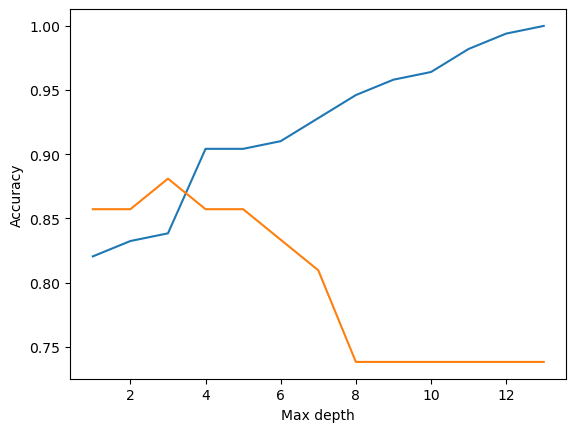

In [16]:
max_depths = range(1, model.get_depth() + 1)
accuracies = []
accuracies_test = []
for max_depth in max_depths:
    model = DecisionTreeClassifier(max_depth=max_depth).fit(X_train, y_train)
    accuracy = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)
    accuracies.append(accuracy)
    accuracies_test.append(accuracy_test)
plt.plot(max_depths, accuracies)
plt.plot(max_depths, accuracies_test)
plt.xlabel("Max depth")
plt.ylabel("Accuracy");

## Validation data for hyperparameter optimization

We have seen that letting the model set the hypterparameters (such as max_depth) in an unconstrained way, will cause it to become very specific to the training data. How can we come up with a good way to find which hyperparameters produce the best generalized model (also called **hyperparameter optimization**)?      
 
It's a good idea to have separate data for tuning the hyperparameters of a model that is not the test set. Enter, the ***validation*** set. 

So we actually want to split our dataset into 3 splits: train, validation, and test.

### Train/validation/test split

- Some of you may have heard of "validation" data.
- Sometimes it's a good idea to have a separate data for hyperparameter tuning. 

![](img/train-valid-test-split.png)

<!-- <img src='img/train-valid-test-split.png' width="1500" height="1500" /> -->

***Note: There isn't a good consensus on the terminology of what is validation and what is test data.***

We use: 
- **training data**: The data used when fitting to find the best model parameters.

- **validation data**: Data where we have access to the target values, but unlike the training data, we only use this for hyperparameter tuning and model assessment; we don't pass these into `fit`.  This evaluation is still biased as skill on the validation dataset is incorporated into the model hyperparameter configuration.

- **test data** (also called holdout data): Data where we have access to the target values, but in this case, unlike training and validation data, we neither use it in training nor hyperparameter optimization and only use it **once** to evaluate the performance of the best performing model on the validation set. We lock it in a "vault" until we're ready to evaluate and it gives a more unbiased performance score than the validation score since the model configuration has not been tweaked to perform well on the test data in any way.

### "Deployment" data

- After we build and finalize a model, we deploy it, and then the model deals with the data in the wild. 
- We will use "deployment" to refer to this data, where we do **not** have access to the target values.
- Deployment error is what we _really_ care about.
- We use validation and test errors as proxies for deployment error, and we hope they are similar.
- So, if our model does well on the validation and test data, we hope it will do well on deployment data.

### Summary of train, validation, test, and deployment data

|         | `fit` | `score` | `predict` |
|----------|-------|---------|-----------|
| Train    | ✔️      | ✔️      | ✔️         |
| Validation |      | ✔️      | ✔️         |
| Test    |       |  once   | once         |
| Deployment    |       |       | ✔️         |

You can typically expect $E_{train} < E_{validation} < E_{test} < E_{deployment}$.

## ❓❓ Questions for you

**Select all of the following statements which are TRUE.**

- (A) A decision tree model with no depth (the default `max_depth` in `sklearn`) is likely to perform very well on the deployment data. 
- (B) Data splitting helps us assess how well our model would generalize. 
- (C) Deployment data is only scored once.  
- (D) Validation data could be used for hyperparameter optimization. 
- (E) It's recommended that data be shuffled before splitting it into `train` and `test` sets.

<details><summary>Solution</summary>(B), (D), (E)</details>

<br><br><br><br>

## Break (5 min)

![](img/eva-coffee.png)


## Cross-validation [[video](https://youtu.be/4cv8VYonepA)]

### Problems with single train/validation split

- Only using a portion of your data for training and only a portion for validation.
- If your dataset is small you might end up with a tiny training and/or validation set.
- You might be unlucky with your splits such that they don't align well or don't well represent your test data.

<!-- <img src='img/train-valid-test-split.png' width="1500" height="1500" /> -->

### Cross-validation to the rescue!! 

Cross-validation (CV) or 𝑘-fold cross-validation. In cross-validation, we perform several training-validation splits and train and evaluate our model across all of them to find the hyperparameters that performs the best on the data in general.

- Split the data into $k$ folds ($k>2$, often $k=10$). In the picture below $k=4$.
- Each "fold" gets a turn at being the validation set.
- Note that cross-validation doesn't shuffle the data; it's done in `train_test_split`.

![](img/cross-validation.png)
<!-- <img src='img/cross-validation.png' width="1500"> -->

- Each fold gives a score and we usually average our $k$ results. 
- It's better to examine the variation in the scores across folds.  
- Gives a more **robust** measure of error on unseen data.

- **Remember** The purpose of the validation data is to to **evaluate** how well models with different hyperparameters will generalize.
- So we do cross-validation to select the model with the most promising hyperparameters, and then we report its score using the hold-out test set.

### Cross-validation using `scikit-learn`

In [17]:
from sklearn.model_selection import cross_validate

#### `cross_validate`

Under the hood:

- It creates `cv` folds on the data.
- In each fold, it fits the model on the training portion and scores on the validation portion. 
- The output is a list of validation scores in each fold.
- Gives us access to training and validation scores.

In [18]:
model = DecisionTreeClassifier(max_depth=4)
scores = pd.DataFrame(cross_validate(model, X_train, y_train, return_train_score=True))
scores

,fit_time,score_time,test_score,train_score
0,0.001864,0.000995,0.970588,0.887218
1,0.001397,0.002534,0.911765,0.902256
2,0.001438,0.000952,0.848485,0.902985
3,0.003048,0.001134,0.818182,0.910448
4,0.001367,0.000993,0.666667,0.932836


**Although the column below is named `test_score` it is referring to the validation data**

By default, 5-fold CV is done, byt you can control it by setting the `cv` parameter, e.g. `cross_validate(..., cv=10)`.

In [19]:
scores.mean()

fit_time       0.001823
score_time     0.001322
test_score     0.843137
train_score    0.907148
dtype: float64

In [20]:
scores.std()

fit_time       0.000714
score_time     0.000681
test_score     0.114833
train_score    0.016652
dtype: float64

#### Our typical supervised learning set up is as follows: 

- We split the data into train and test portions: `train_df`, `test_df`.
- We are divide these into features `X_train`/`X_test` and target `y_train`/`y_test`.
- We carry out hyperparameter optimization using cross-validation on the train portion: `X_train` and `y_train`. 
- We assess our best performing model on the test portion: `X_test` and `y_test`.  
- What we care about is the **test error**, which tells us how well our model can be generalized.
- If this test error is "reasonable" we deploy the model which will be used on new unseen examples.

- How do we know whether this test score is reasonable? 

## Underfitting, overfitting, the fundamental trade-off, the golden rule [[video](https://youtu.be/Ihay8yE5KTI)]

Previously when we looked at which was the best `max_depth`, we used the test set to report the accuracy.
However, remember the **golden rule**!
We cannot use any information from the test set to select our model/hyperparameters, this is what we use the validation set for (via crossvalidation).

Let's go through all the steps from the beginning:

In [21]:
df = pd.read_csv("data/canada_usa_cities.csv")

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=132
)

# We can train our model and do EDA on our train data
X_train = train_df.drop(columns=["country"])
y_train = train_df["country"]

# We don't look at our test data until we score the model
X_test = test_df.drop(columns=["country"])
y_test = test_df["country"]

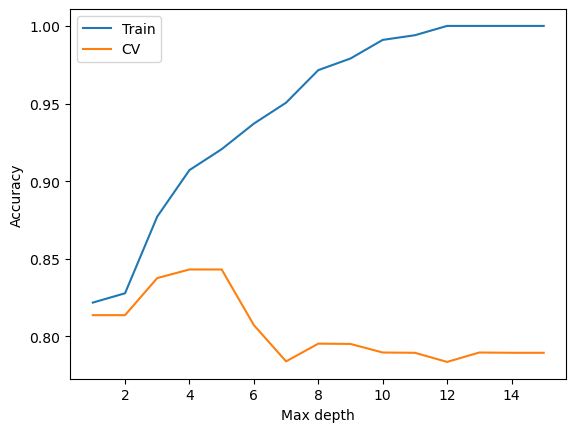

In [22]:
# Find the best hyperparameters on the validation data
mean_accuracies_train = []
mean_accuracies_cv = []
max_depth_range = range(1, 16)
for depth in max_depth_range:
    model = DecisionTreeClassifier(max_depth=depth)
    scores = cross_validate(model, X_train, y_train, return_train_score=True)
    mean_accuracies_cv.append(scores["test_score"].mean())
    mean_accuracies_train.append(scores["train_score"].mean())
plt.plot(max_depth_range, mean_accuracies_train, label='Train')
plt.plot(max_depth_range, mean_accuracies_cv, label='CV')
plt.legend()
plt.xlabel("Max depth")
plt.ylabel("Accuracy");

- We can see that the validation error does not necessarily decrease with the training error. 
- To the left in the plot, the model has not been able to pick up enough of the true underlying relationship between the features and target from the training data.
    - This is called **underfitting** and occrus when both the training and validation data accuracy is low.
- To the right of the plot, the model has started to rely too much on the training data, and is picking up things like noise instead of the general trend of the data.
    - This is called **overfitting** and occrus when both the training data accuracy is high, but the validation data accuracy is low.

### The "fundamental tradeoff" of supervised learning:


**As you increase model complexity, the training data accuracy tend to go up but the validation data accuracy tends to go down.**

This balance between underfitting and overfitting is also called the "variance-bias" tradeoff:

- Too high bias in the model corresponds to underfitting (indicates that it hasn't picked up the true relationship)
- Too high variance in the model corresponds to overfitting (indicates that is has picked up on noise in the training data)
- There are many subtleties here and there is no perfect answer but a  common practice is to pick the model with minimum cross-validation error. 

### How to pick a model that would generalize better?

- We want to avoid both underfitting and overfitting. 
- We want to be consistent with the training data but we don't to rely too much on it. 

<!-- <center>
<img src='img/malp_0201.png' width="800" height="800" />
</center>    
 -->
<!-- ![](img/malp_0201.png) -->
<img src='img/malp_0201.png' width="800" height="800" />

[source](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch02.html#relation-of-model-complexity-to-dataset-size)

As an ML practitioner, before finalizing the model (before assessing the model on the test set), it’s a good idea to come up with a set of candidate models based on mean cross-validation score (e.g., top 5 models ranked by their CV scores). Then you might want to consider the following criteria to evaluate these candidate models.
the cross-validation score is close to the best cross-validation score
the gap between train and cross-validation is not that large
there is not much variation in the cross-validation sub-scores
the model is simpler
In general, these are difficult questions and there is no one correct answer. In real life, when you pick a certain model, it’s a good idea to provide a convincing justification of why you picked this specific model.

<br><br><br><br>

In [23]:
depth=13
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_train, y_train)
# scores = cross_validate(model, X_train, y_train, return_train_score=True)
model.score(X_test, y_test)

0.7380952380952381

- The test error is a bit worse than the cross-validation error (remember CV is just an estimation of the unseen data).
- Do we feel confident that this model would give similar performace when deployed? 

As you have seen there are several steps here, and in the nextt sessions we will see how pipelines can make it concistent so that we don't accidentally leak information from the test data into our model selection and violate the golden rule.

## ❓❓ Questions for you

**Select all of the following statements which are TRUE.**

- (A) $k$-fold cross-validation calls fit $k$ times.
- (B) We use cross-validation to get a more robust estimate of model performance.
- (C) If the mean train accuracy is much higher than the mean cross-validation accuracy it's likely to be a case of overfitting.
- (D) The fundamental tradeoff of ML states that as training error goes down, validation error goes up.
- (E) A decision stump on a complicated classification problem is likely to underfit. 

<details><summary>Solutions</summary>(A), (B), (C), (E)</details>

<br><br>

**Select all of the following situations where you would probably trust the scores.**

- (A) You have a dataset and you give me half of it. I build a model using all the data you have given me and I tell you that the model accuracy is 0.99. 
- (B) You have a dataset and you give me half of it. I use 80% of the data to tune the model with cross-validation. I report CV accuracy of 0.91 and 0.90 accuracy on the 20% test data. 

<details><summary>Solutions</summary>(B)</details>

### What did we learn today?

- Importance of generalization in supervised machine learning 
- Data splitting as a way to approximate generalization error 
- Train, test, validation, deployment data
- Cross-validation
- A typical sequence of steps to train supervised machine learning models
    - training the model on the train split
    - tuning hyperparamters using the validation split
    - checking the generalization performance on the test split 
- Overfitting, underfitting, the fundamental tradeoff, and the golden rule.   

![](img/eva-seeyou.png)